In [2]:
# Importing librosa, soundfile, pandas, os, glob, pickle, numpy, matplotlib, seaborn and warnings in the lines below
import librosa
import librosa.display
import soundfile
import pandas as pd
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress specific FutureWarnings related to seaborn and pandas
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

load_dotenv()
sound_path = os.getenv('audio_path')

In [3]:
data = pd.read_csv('voice_data_dw.csv')

In [4]:
df = pd.DataFrame(data)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,...,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,mel_mean,mel_max,mel_min,mel_median
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.957471,7.346735,...,1.404669,0.035216,-0.366837,0.402055,0.026985,0.324578,0.008900,0.123322,2.614395e-06,0.001299
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.089419,8.214594,...,1.421661,0.035165,-0.321986,0.370448,0.019657,0.289828,0.010221,0.145016,2.725123e-06,0.001334
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.454927,10.036692,...,1.343759,0.019878,-0.366093,0.372867,0.024859,0.304296,0.014091,0.192971,1.924749e-06,0.001967
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.550832,10.230623,...,1.403482,-0.087634,-0.496947,0.397968,0.032695,0.312490,0.013258,0.171779,2.575075e-06,0.001854
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.393763,9.301793,...,1.403229,0.012420,0.076644,0.390425,0.018674,0.306337,0.004342,0.062087,4.320785e-07,0.000367


In [5]:
df.describe()

,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,...,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,mel_mean,mel_max,mel_min,mel_median
count,1440.0,1440.0,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03,1440.000000
mean,3.0,1.0,4.733333,1.466667,1.500000,1.500000,1.500000,-12.031011,20.984330,-44.324364,...,1.650572,-0.088766,0.149908,0.337513,0.008449,0.241075,0.340549,7.308005,1.214139e-05,0.011263
std,0.0,0.0,2.175356,0.499061,0.500174,0.500174,0.500174,2.453137,6.539893,3.523693,...,0.242438,0.086862,0.362336,0.058984,0.008855,0.086064,0.923560,20.211290,3.570334e-05,0.034965
min,3.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,-17.447968,5.965159,-55.467552,...,0.981710,-0.362531,-0.531214,0.209584,0.000000,0.083002,0.000148,0.001676,0.000000e+00,0.000003
25%,3.0,1.0,3.000000,1.000000,1.000000,1.000000,1.000000,-13.736770,15.939935,-46.812098,...,1.470090,-0.147356,-0.098944,0.293353,0.002402,0.176937,0.010569,0.185627,2.987623e-07,0.000614
50%,3.0,1.0,5.000000,1.000000,1.500000,1.500000,1.500000,-12.373409,21.527895,-44.522983,...,1.665268,-0.087225,0.080504,0.328985,0.004504,0.227825,0.043046,0.781876,1.403833e-06,0.001868
75%,3.0,1.0,7.000000,2.000000,2.000000,2.000000,2.000000,-10.810267,25.941390,-41.803038,...,1.831518,-0.024742,0.317916,0.371776,0.012222,0.287192,0.169337,3.447609,6.937701e-06,0.006642
max,3.0,1.0,8.000000,2.000000,2.000000,2.000000,2.000000,-2.102572,37.776104,-34.421993,...,2.347308,0.184235,2.010405,0.577242,0.063414,0.635891,9.398663,213.199940,4.157495e-04,0.544874


# Need PCA, principal component analysis

normalizing features

In [6]:
from sklearn.preprocessing import StandardScaler

# Scale DataFrame
scaler = StandardScaler()

# col = df.columns[4:]     FIX for columns but it also needs to happen after train test split

# Columns selected to be scaled
feature_columns = col  # Adding all feature columns

# Fit and transform the data
df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [7]:
df.iloc[:,8:].corr()

,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_delta_max,mfcc_delta_min,mfcc_delta_std,mfcc_delta_kurtosis,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_std,chroma_min
mfcc_mean,1.000000,0.574350,0.355658,0.956225,0.305139,0.232085,-0.283474,0.281218,-0.034369,0.313754,-0.268977,0.317922,-0.070974
mfcc_max,0.574350,1.000000,-0.412161,0.416647,0.894474,0.826936,-0.881419,0.817556,0.305529,0.842984,-0.873904,0.776714,-0.637346
mfcc_min,0.355658,-0.412161,1.000000,0.396953,-0.678161,-0.693082,0.663644,-0.613989,-0.264221,-0.632311,0.637743,-0.510044,0.509946
mfcc_median,0.956225,0.416647,0.396953,1.000000,0.191444,0.132086,-0.147701,0.119112,-0.000696,0.203852,-0.128834,0.150824,0.085135
mfcc_std,0.305139,0.894474,-0.678161,0.191444,1.000000,0.871561,-0.890582,0.829854,0.345705,0.844563,-0.863178,0.743966,-0.650468
mfcc_delta_max,0.232085,0.826936,-0.693082,0.132086,0.871561,1.000000,-0.916544,0.852925,0.359378,0.903484,-0.894196,0.729869,-0.589045
mfcc_delta_min,-0.283474,-0.881419,0.663644,-0.147701,-0.890582,-0.916544,1.000000,-0.914739,-0.283142,-0.908612,0.923148,-0.819344,0.654779
mfcc_delta_std,0.281218,0.817556,-0.613989,0.119112,0.829854,0.852925,-0.914739,1.000000,-0.039192,0.865717,-0.880072,0.929768,-0.627840
mfcc_delta_kurtosis,-0.034369,0.305529,-0.264221,-0.000696,0.345705,0.359378,-0.283142,-0.039192,1.000000,0.235462,-0.265763,-0.126252,-0.208174
mfcc_delta2_max,0.313754,0.842984,-0.632311,0.203852,0.844563,0.903484,-0.908612,0.865717,0.235462,1.000000,-0.943649,0.857590,-0.581350


In [ ]:
# Pairplot of the voice data
sns.pairplot(df)
plt.show()

Steps for Improvement:
Hyperparameter Tuning: Adjusting the parameters of the Random Forest, like the number of trees (n_estimators), depth of the 
    trees, etc., could improve performance.
Feature Engineering: Exploring different or additional features extracted from the audio data might enhance the model's 
    ability to distinguish between emotions.

Let's proceed with evaluating the Random Forest Classifier on the test set. We'll use the same metrics as before: 
    accuracy, precision, recall, and F1-score. This will provide a comprehensive view of the model's performance.

Test Accuracy: Approximately 46.5%
Classification Report:
Precision, recall, and F1-score for each emotion class (1 to 8) are shown.
The model shows varied performance across different emotions, similar to the validation results.

Hyperparameter Tuning: Experimenting with different settings of the Random Forest parameters might enhance performance.
Feature Engineering: Exploring additional audio features or different methods of feature extraction could provide the model with more discriminative information.
Advanced Modeling Techniques: Investigating other machine learning or deep learning models, especially those tailored for audio and speech analysis, could yield better results.
Data Augmentation: If applicable, increasing the size and diversity of the training data through augmentation techniques might improve the model's robustness and accuracy.

Additional features:
    
    
Mel-Frequency Cepstral Coefficients (MFCCs):

You're already using MFCCs, but you can experiment with the number of coefficients. Typically, the first 13-20 coefficients are used.
Delta and Delta-Delta (derivative and acceleration) of MFCCs can provide information about the rate of change in features.


Spectral Features:

Spectral Centroid: Indicates where the "center of mass" for a sound is located and is a measure of the brightness of a sound.

Spectral Roll-off: The frequency below which a certain percentage of the total spectral energy (e.g., 85%) is contained.

Spectral Bandwidth: The width of the band of light at one-half the peak maximum (or full width at half maximum).


Zero Crossing Rate:

The rate at which the signal changes from positive to negative or back. This feature is often used to characterize the noisiness or the tonal content of the sound.


Chroma Features:

Chroma features are a powerful tool for analyzing music, capturing harmonic and melodic characteristics. They relate to the 12 different pitch classes.


Tempo:

The speed or pace of a given piece, which could be linked with certain emotions in the context of music.


Energy and RMS:

The energy of a signal corresponds to the total magnitude of the signal.
Root Mean Square (RMS) energy is useful to identify the amount of power in an audio signal.


Harmonic and Percussive Components:

Separating the harmonic and percussive elements of audio can be useful, especially in distinguishing speech from background noise or music.


Tonnetz:

Represents the tonal centroids as a 6-dimensional vector (harmonic relations between tones in Western music).
Statistical Features:

Applying statistical functions like mean, median, variance, skewness, kurtosis, etc., to the above features, over time or frequency bins, can yield more descriptive features.

Hyperparameter tuning

Number of Trees (n_estimators): The number of trees in the forest. More trees can improve performance but also increase computational cost.

Maximum Depth of Trees (max_depth): The maximum depth of each tree. Deeper trees can model more complex patterns but may lead to overfitting.

Minimum Samples Split (min_samples_split): The minimum number of samples required to split an internal node. Higher values prevent creating nodes that model noise.

Minimum Samples Leaf (min_samples_leaf): The minimum number of samples required to be at a leaf node. Smaller leaf size makes the model more prone to capturing noise in train data.

Maximum Features (max_features): The number of features to consider when looking for the best split. Trying different values can lead to significant model improvements.

Bootstrap (bootstrap): Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

The Randomized Search has completed, but it seems the output for the best parameters was not captured. This is typically due to the execution environment or time constraints in processing.

However, in your own setup, after running the RandomizedSearchCV, you would get the best parameters from random_search.best_params_. These parameters are the ones that the search found to be the most effective within the specified parameter grid.

Here's how you would typically proceed:

Use the Best Parameters: Apply these best parameters to the Random Forest Classifier.
Re-train the Model: Train a new Random Forest Classifier using these optimized hyperparameters.
Evaluate Performance: Evaluate the performance of this tuned model on the validation set, and if satisfactory, test it on the test set.

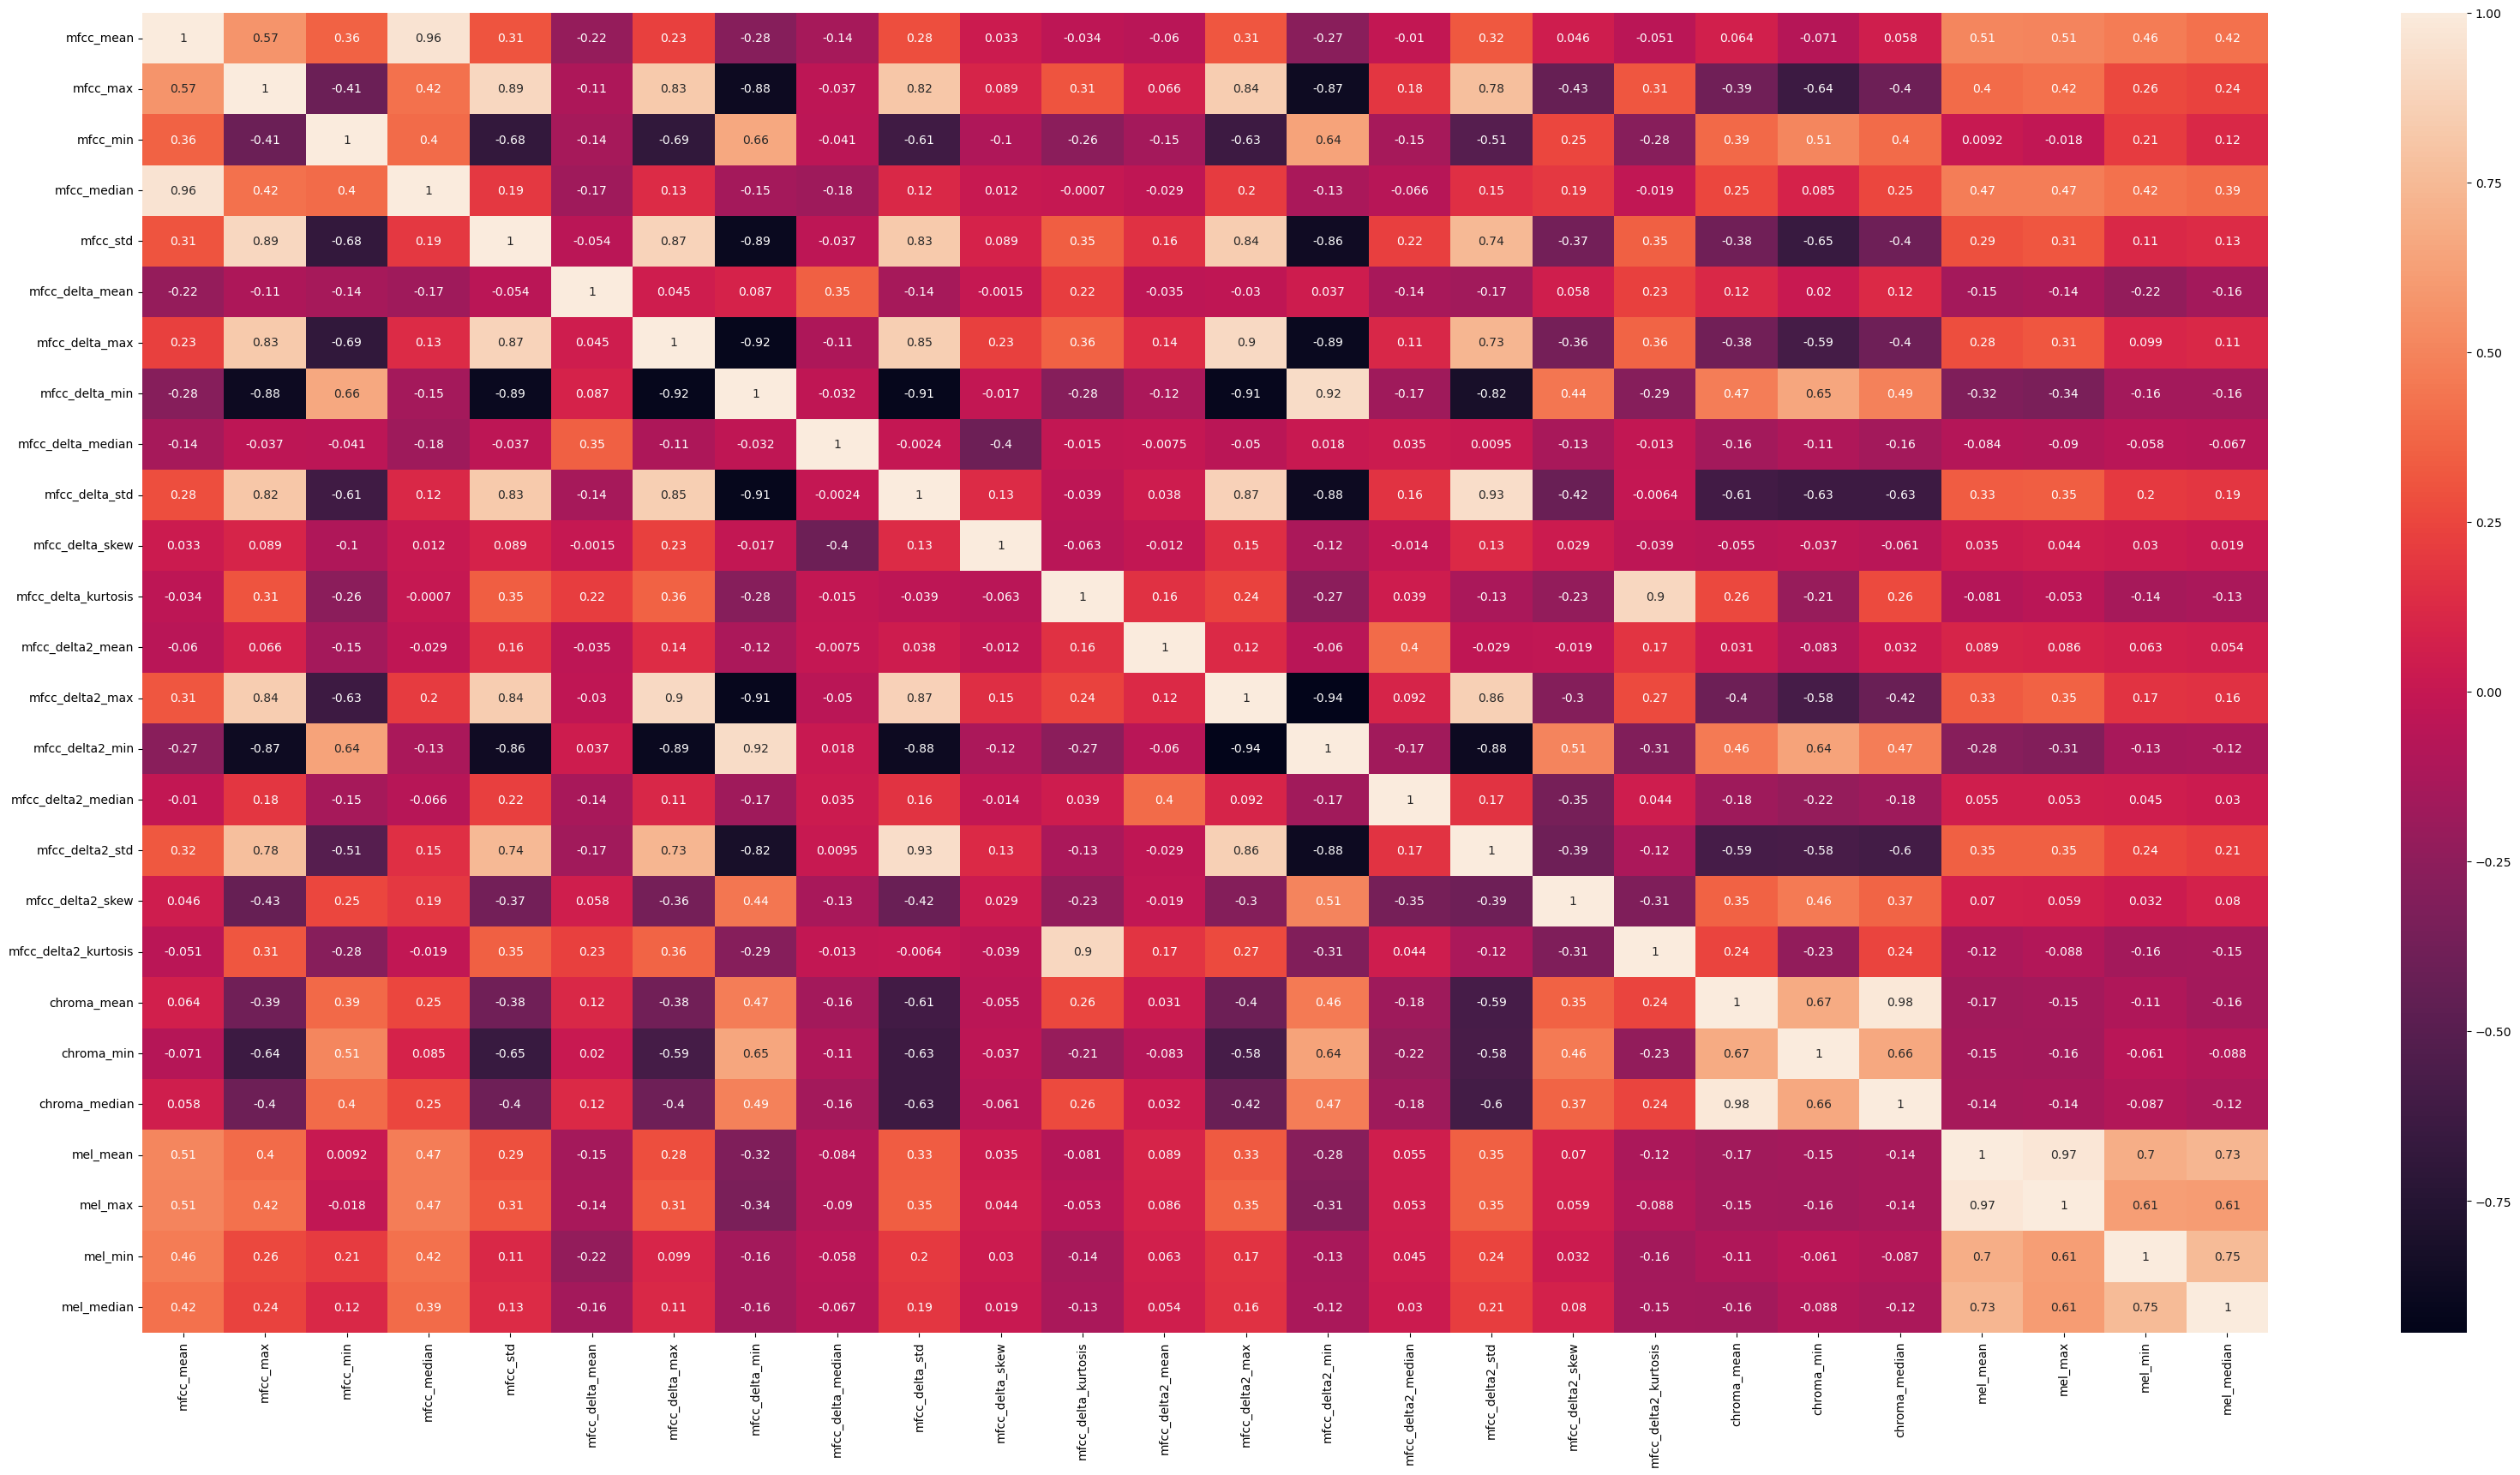

In [50]:
# Make a heatmap of the data
plt.figure(figsize=(40,20))
sns.heatmap(df.iloc[:,8:].corr(), annot=True)
plt.show()

Model training > Logistic Regression > Random Forest Classifier > Gradient Boosting Classifier

use feature importance to help eliminate noise

### KNN

In [8]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion', 'voice_intensity',
       'statement', 'statement_repetition', 'actor_gender', 'mfcc_mean',
       'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std', 'mfcc_delta_mean',
       'mfcc_delta_max', 'mfcc_delta_min', 'mfcc_delta_median',
       'mfcc_delta_std', 'mfcc_delta_skew', 'mfcc_delta_kurtosis',
       'mfcc_delta2_mean', 'mfcc_delta2_max', 'mfcc_delta2_min',
       'mfcc_delta2_median', 'mfcc_delta2_std', 'mfcc_delta2_skew',
       'mfcc_delta2_kurtosis', 'chroma_mean', 'chroma_min', 'chroma_median',
       'mel_mean', 'mel_max', 'mel_min', 'mel_median'],
      dtype='object')

In [51]:
X = df[['mfcc_delta_max', 'mfcc_delta_min']].values
y = df['emotion'].values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1440, 2) (1440,)
(1008, 2) (432, 2) (1008,) (432,)


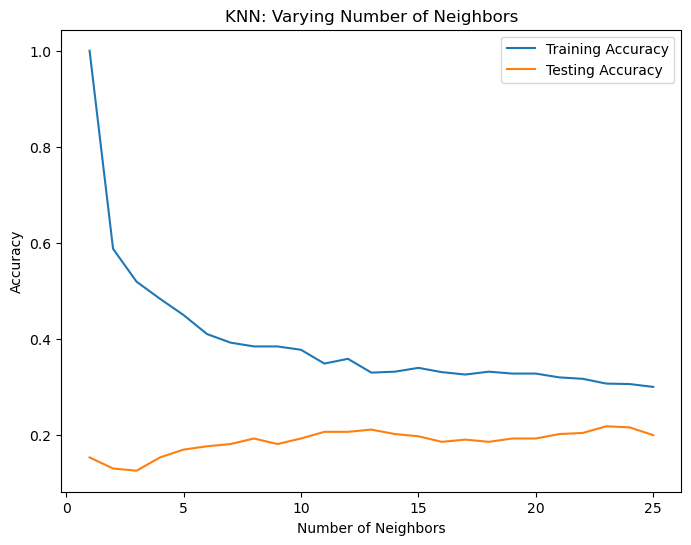

In [52]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 26)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)
    
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [42]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [43]:
print(knn.score(X_test, y_test))

0.2708333333333333


In [ ]:
# checking for data leakage
'emotion' in X.columns  # Should be False

## Linear Regression

In [24]:
X = df[['mfcc_delta2_max']].values
y = df['emotion'].values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size=0.3, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1440, 1) (1440,)
(1008, 1) (432, 1) (1008,) (432,)


In [25]:
# checking for data leakage
'emotion' in X.columns  # Should be False

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

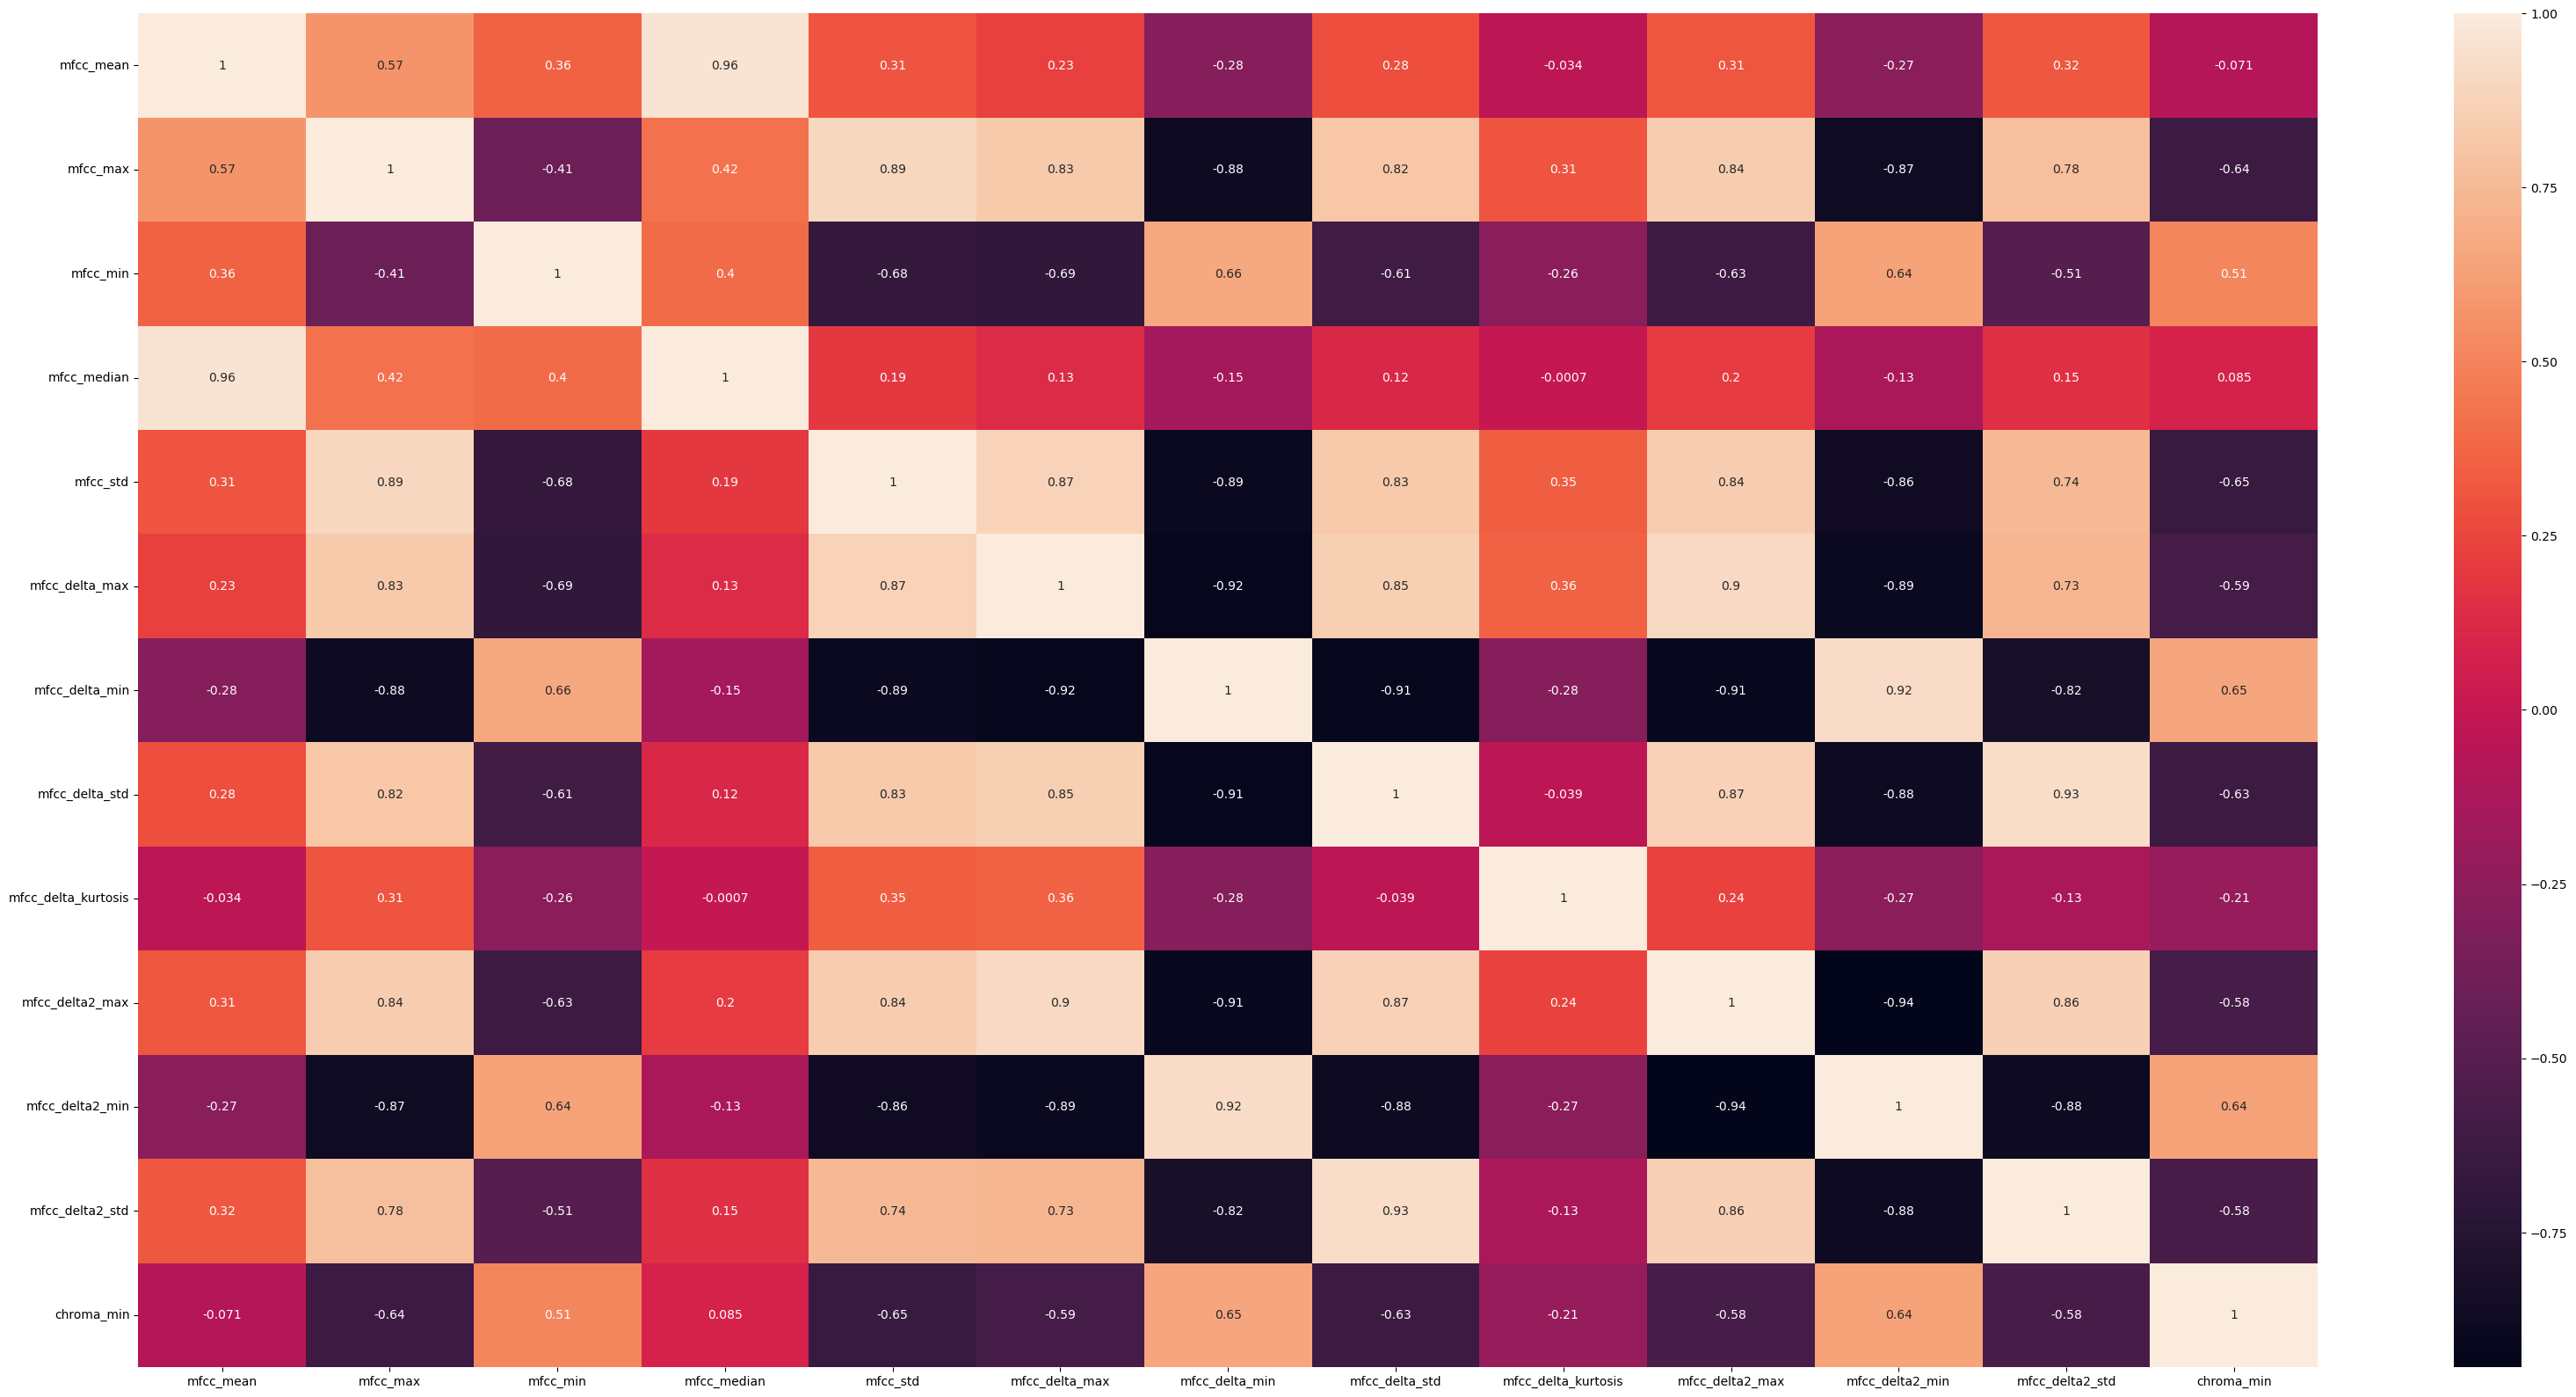

In [8]:
# Make a heatmap of the data
plt.figure(figsize=(40,20))
sns.heatmap(df.iloc[:,8:].corr(), annot=True)
plt.show()

In [8]:
# Extended feature extraction function
def extract_feature(file_name, mfcc, chroma, mel, centroid, roll_off, bandwidth, tempo, energy, rms, harmonic, percussive, tonnetz):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or centroid or roll_off or bandwidth:
            stft = np.abs(librosa.stft(X))
        
        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
        if centroid:
            centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, centroid))
        if roll_off:
            roll_off = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, roll_off))
        if bandwidth:
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, bandwidth))
        if tempo:
            onset_env = librosa.onset.onset_strength(y=X, sr=sample_rate)
            tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_env, sr=sample_rate)
            result = np.hstack((result, tempo))
        if energy:
            energy = np.array([np.sum(np.square(X))])
            result = np.hstack((result, energy))
        if rms:
            rms = np.mean(librosa.feature.rms(y=X).T, axis=0)
            result = np.hstack((result, rms))
        if harmonic or percussive:
            y_harmonic, y_percussive = librosa.effects.hpss(X)
            if harmonic:
                harmonic = np.mean(y_harmonic)
                result = np.hstack((result, harmonic))
            if percussive:
                percussive = np.mean(y_percussive)
                result = np.hstack((result, percussive))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz))

        return result


In [ ]:
# # Extract features (mfcc, chroma, mel) from a sound file
# def extract_feature(file_name, mfcc, chroma, mel):
#     with soundfile.SoundFile(file_name) as sound_file:
#         X = sound_file.read(dtype="float32")
#         sample_rate=sound_file.samplerate
#         if chroma:
#             stft=np.abs(librosa.stft(X))
#         result=np.array([])
#         if mfcc:
#             mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#             result=np.hstack((result, mfccs))
#         if chroma:
#             chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, chroma))
#         if mel:
#             mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, mel))
#     return result

In [9]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
# observed_emotions=['calm', 'happy', 'fearful', 'disgust']
observed_emotions=['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [ ]:
# # Load the data and extract features for each sound file
# def load_data(test_size=0.2):
#     x,y=[],[]
#     for file in glob.glob("D:\\DataFlair\\ravdess data\\Actor_*\\*.wav"):
#         file_name=os.path.basename(file)
#         emotion=emotions[file_name.split("-")[2]]
#         if emotion not in observed_emotions:
#             continue
#         feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
#         x.append(feature)
#         y.append(emotion)
#     return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [10]:
# Updated load_data function
def load_data(test_size=0.2, mfcc=False, chroma=False, mel=True, centroid=True, roll_off=True, bandwidth=False, tempo=False, energy=True, rms=False, harmonic=True, percussive=False, tonnetz=False):
    x, y = [], []
    for file in glob.glob(f'{sound_path}/ravdess-data/Actor_*/*.wav'):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=mfcc, chroma=chroma, mel=mel, centroid=centroid, roll_off=roll_off, bandwidth=bandwidth, tempo=tempo, energy=energy, rms=rms, harmonic=harmonic, percussive=percussive, tonnetz=tonnetz)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)


## Random Forrest Classifier

In [10]:
# Load your data
X_train, X_test, y_train, y_test = load_data(test_size=0.2, mfcc=True, chroma=True, mel=True, centroid=True, roll_off=True, bandwidth=True, tempo=True, energy=True, rms=True, harmonic=True, percussive=True, tonnetz=True)

AttributeError: No librosa.feature attribute rhythm

In [81]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [82]:
feature_importances = model.feature_importances_
feature_names = ['MFCC', 'Chroma', 'Mel', 'Centroid', 'Roll_off', 'Bandwidth', 'Tempo', 'Energy', 'RMS', 'Harmonic', 'Percussive', 'Tonnetz']  # Update this list based on the actual features used
importances = dict(zip(feature_names, feature_importances))

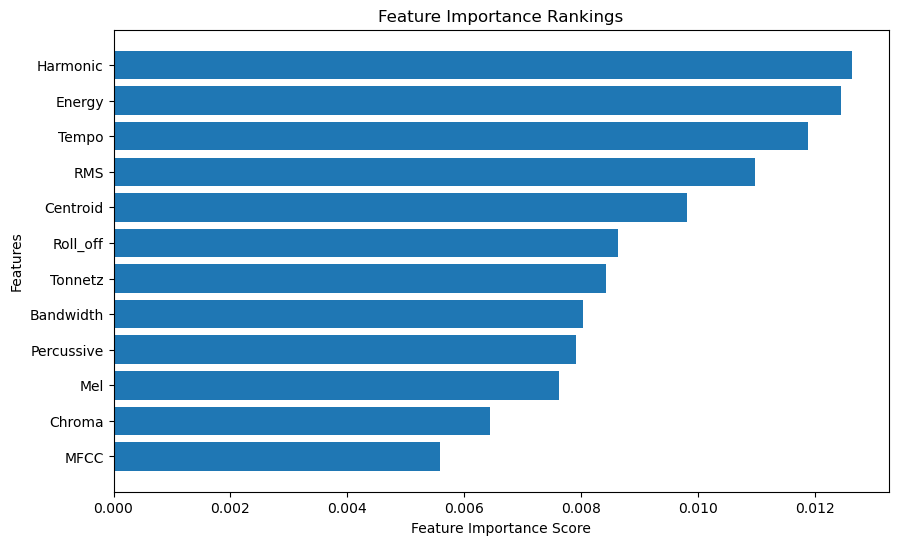

In [83]:
import matplotlib.pyplot as plt

# Sort features by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and scores
sorted_features = [x[0] for x in sorted_importances]
sorted_scores = [x[1] for x in sorted_importances]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_scores)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Rankings')
plt.gca().invert_yaxis()
plt.show()

## Multi Layer Perception Classifier

In [11]:
# Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [74]:
# Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(1008, 336)


In [75]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 132


In [76]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [77]:
# Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [78]:
# Predict for the test set
y_pred=model.predict(x_test)

In [79]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 22.32%


In [35]:
# # Number of bootstrap samples
# n_iterations = 10

# # Array to store scores
# scores = []

# for i in range(n_iterations):
#     # Prepare bootstrap sample
#     x_train_boot, y_train_boot = resample(x_train, y_train)

#     # Create a new model instance
#     model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)

#     # Train the model on bootstrap sample
#     model.fit(x_train_boot, y_train_boot)

#     # Evaluate the model on the original test set
#     y_pred = model.predict(x_test)
#     score = accuracy_score(y_test, y_pred)
#     scores.append(score)
    
# # Calculate average performance
# average_performance = np.mean(scores)
# print(f'Average Accuracy: {average_performance * 100:.2f}%')

Average Accuracy: 55.62%


In [16]:
# Exporting to CSV file
df.to_csv('voice_data_eda.csv', index=False)